In [1]:
import itertools

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
from geopy.distance import geodesic
from railroad import load_graph, save_graph, create_subgraph, plot_node_graph, test_road_graph
from utils import print_graph_info
from utils import osmnx_to_geopandas

from utils import compute_length

import numpy as np
import contextily as ctx

In [2]:
G = load_graph('../data/reykjavik_road_graph.json')
G

In [3]:
# Identify self-loops
self_loops = list(nx.selfloop_edges(G))

# Remove self-loops
G.remove_edges_from(self_loops)

print(f"Removed {len(self_loops)} self-loops from the graph.")

Removed 139 self-loops from the graph.


In [4]:
# Identify nodes without geometry
nodes_without_geometry = [node for node, data in G.nodes(
    data=True) if 'geometry' not in data]

# Remove nodes without geometry
G.remove_nodes_from(nodes_without_geometry)

print(
    f"Removed {len(nodes_without_geometry)} nodes without geometry from the graph.")

Removed 0 nodes without geometry from the graph.


In [5]:
G.nodes[1848219055]

{'street_count': 3, 'geometry': <POINT (-21.81 64.086)>}

In [6]:
for source, target, key, data in G.edges(keys=True, data=True):
    if 'geometry' not in data or data['geometry'] is None:
        # Create a simple straight line geometry between source and target nodes
        source_pos = G.nodes[source]['geometry']
        target_pos = G.nodes[target]['geometry']
        line = LineString([source_pos, target_pos])
        data['geometry'] = line

In [7]:
node_id_1 = 281356890
node_id_2 = 26932436

print(G.nodes[node_id_1])
print(G.nodes[node_id_2])
# Access the edge with the correct key
print(G.edges[node_id_1, node_id_2, 0])
print(G.edges[node_id_1, node_id_2, 0]['geometry'])
print(G.edges[node_id_2, node_id_1, 0])

# Define the point to compare
point = Point(-21.931079, 64.123404)
print(type(point))

# Get the geometry of the edge
line = G.edges[node_id_1, node_id_2, 0]['geometry']
print(type(line))

# Find the nearest point on the line to the given point
nearest_point = nearest_points(line, point)[0]
print(nearest_point)

{'street_count': 3, 'geometry': <POINT (-21.93 64.126)>}
{'street_count': 3, 'geometry': <POINT (-21.927 64.123)>}
{'osmid': [25794811, 132532683, 160479839], 'oneway': False, 'lanes': '2', 'name': 'Nauthólsvegur', 'highway': 'residential', 'maxspeed': ['40', '30'], 'reversed': False, 'length': 560.6089999999999, 'geometry': <LINESTRING (-21.93 64.126, -21.93 64.126, -21.93 64.126, -21.931 64.125, -2...>}
LINESTRING (-21.929709 64.1258217, -21.9298352 64.1257442, -21.9299836 64.1256161, -21.9307033 64.1249212, -21.9309873 64.1245524, -21.9311089 64.1242898, -21.9311854 64.1240432, -21.9312058 64.1238486, -21.9311773 64.1236088, -21.9310842 64.1234004, -21.9309724 64.1231646, -21.9309018 64.1230462, -21.9307885 64.1229145, -21.9307583 64.1228914, -21.9306823 64.1228332, -21.9304663 64.1227192, -21.9303333 64.1226709, -21.930137 64.1226232, -21.9299763 64.1225952, -21.9297479 64.1225674, -21.9295231 64.1225583, -21.9287994 64.1225794, -21.9283217 64.1225933, -21.926573 64.1226516)
{'osmi

In [8]:
def split_bidirectional_edge_at_point(graph, node1, node2, point, new_node_id=None):
    """
    Split bidirectional edges in the directed multigraph `graph` between `node1` and `node2`
    at the nearest point to `point`, adding a new node at the split point.

    Parameters:
    - graph: nx.DiGraph - Directed multigraph
    - node1: int - Source node of the edge
    - node2: int - Target node of the edge
    - point: shapely.geometry.Point - The point to split the edges at

    Returns:
    - int: ID of the newly created node
    """
    # Function to handle splitting a single edge
    def split_single_edge(graph, src, tgt, point):
        # Check for single edge between src and tgt
        if graph.number_of_edges(src, tgt) != 1:
            raise ValueError(
                f"Graph has more than one edge between nodes {src} and {tgt}.")

        # Access the edge data
        edge_data = graph[src][tgt][0]

        # Extract the edge geometry
        line = edge_data['geometry']
        if not isinstance(line, LineString):
            raise TypeError(f"Edge geometry is not a LineString: {line}")

        # Find the nearest point on the edge to the given point
        nearest_point = nearest_points(line, point)[0]

        # Split the LineString into two parts at the nearest point
        coords = list(line.coords)
        split_index = None
        for i, (x, y) in enumerate(coords[:-1]):
            segment = LineString([coords[i], coords[i + 1]])
            # Adjust tolerance if necessary
            if segment.distance(nearest_point) < 1e-9:
                split_index = i + 1
                break

        if split_index is None:
            raise ValueError("Unable to determine split index.")

        part1 = LineString(coords[:split_index] + [nearest_point.coords[0]])
        part2 = LineString([nearest_point.coords[0]] + coords[split_index:])

        # Remove the original edge
        graph.remove_edge(src, tgt)

        # Add the new edges
        edge_attrs = {k: v for k, v in edge_data.items() if k != 'geometry'}
        graph.add_edge(src, new_node_id, geometry=part1, **edge_attrs)
        graph.add_edge(new_node_id, tgt, geometry=part2, **edge_attrs)

    # Add a new node for the split point
    new_node_id = new_node_id or max(graph.nodes) + 1
    graph.add_node(new_node_id, geometry=point)

    # Split the edge in the forward direction
    if graph.has_edge(node1, node2):
        split_single_edge(graph, node1, node2, point)

    # Split the edge in the reverse direction, if it exists
    if graph.has_edge(node2, node1):
        split_single_edge(graph, node2, node1, point)

    return new_node_id

In [9]:
def add_edge_with_geometry(graph, node1, node2, attributes=None):
    """
    Add a directed edge between two nodes with a straight-line geometry in a directional graph.

    Parameters:
    - graph: nx.DiGraph - The graph to which the edge will be added.
    - node1: int - Source node ID.
    - node2: int - Target node ID.
    - attributes: dict - Additional attributes to include in the edge (optional).

    Returns:
    - None
    """
    # Ensure the nodes exist in the graph
    if node1 not in graph.nodes or node2 not in graph.nodes:
        raise ValueError(
            f"One or both nodes {node1}, {node2} are not in the graph.")

    # Retrieve the coordinates of the nodes
    node1_pos = graph.nodes[node1]['geometry']
    node2_pos = graph.nodes[node2]['geometry']

    # Create a straight-line geometry between the two nodes
    line = LineString([node1_pos, node2_pos])

    # Set edge attributes, including geometry
    edge_attrs = {'geometry': line}
    if attributes:
        edge_attrs.update(attributes)

    # Add the edge to the graph
    graph.add_edge(node1, node2, **edge_attrs)

    line = LineString([node2_pos, node1_pos])
    edge_attrs = {'geometry': line}
    if attributes:
        edge_attrs.update(attributes)

    graph.add_edge(node2, node1, **edge_attrs)

In [10]:

# Example usage
point = Point(-21.931079, 64.123404)
new_node = split_bidirectional_edge_at_point(
    G, node_id_1, node_id_2, point, 12339218091)
print(f"New node added with ID: {new_node}")

New node added with ID: 12339218091


In [11]:
G.nodes[12339218091]

{'geometry': <POINT (-21.931 64.123)>}

In [12]:
G.add_node(12339218092, geometry=Point(-21.935, 64.121))
add_edge_with_geometry(G, 12339218091, 12339218092)
add_edge_with_geometry(G, 11142383860, 12339218092)

In [13]:
add_edge_with_geometry(G, 1344359843, 87135172)

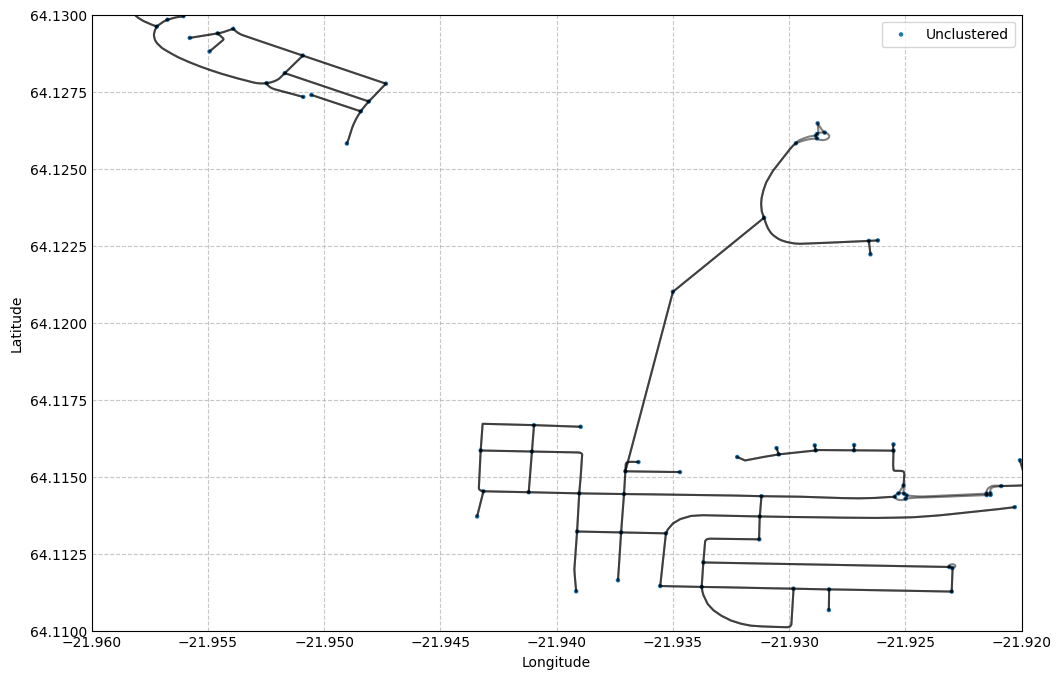

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

In [14]:
plot_node_graph(G, xlim=(-21.96, -21.92), ylim=(64.11, 64.13),
                show_node_ids=False, show_nodes_labels=False, node_size=5, add_map=False)

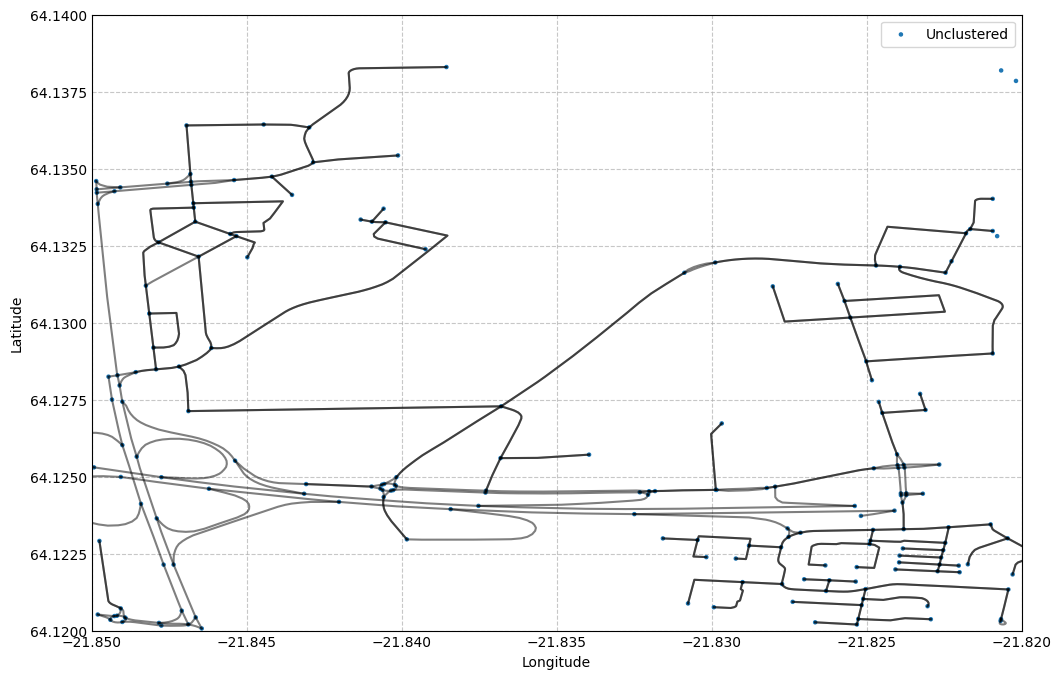

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

In [15]:
plot_node_graph(G, xlim=(-21.85, -21.82), ylim=(64.12, 64.14),
                show_node_ids=False, show_nodes_labels=False, node_size=5, add_map=False)

In [16]:
add_edge_with_geometry(G, 633181062, 34165029)
add_edge_with_geometry(G, 34165029, 1064270444)

In [17]:
G.add_node(12339218093, geometry=Point(-21.914030, 64.143340))
add_edge_with_geometry(G, 1221993745, 12339218093)
add_edge_with_geometry(G, 1511581335, 12339218093)

In [18]:
add_edge_with_geometry(G, 36156319, 1344359843)

In [19]:
add_edge_with_geometry(G, 1366034562, 1232404964)
add_edge_with_geometry(G, 1232404955, 306597426)

In [20]:
add_edge_with_geometry(G, 34186922, 27237169)

In [21]:
add_edge_with_geometry(G, 34186922, 36156319)

In [22]:
add_edge_with_geometry(G, 137875110, 87110390)
add_edge_with_geometry(G, 1770032467, 349327744)

In [23]:
for u, v, key, data in G.edges(keys=True, data=True):
    if 'geometry' in data:
        data['length'] = compute_length(data['geometry'])
    else:
        data['length'] = np.infty

In [24]:
for id_in, id_out, data in G.edges(data=True):
    line = data['geometry']
    from_point = G.nodes[id_in]['geometry']
    to_point = G.nodes[id_out]['geometry']

    # Define line_start and line_end for clarity and reuse
    line_start = Point(line.coords[0])
    line_end = Point(line.coords[-1])

    distance_between_stations = geodesic(
        (from_point.x, from_point.y), (to_point.x, to_point.y)).meters
    distance_in_start = geodesic(
        (line_start.x, line_start.y), (from_point.x, from_point.y)).meters
    distance_in_end = geodesic(
        (line_end.x, line_end.y), (from_point.x, from_point.y)).meters
    distance_out_start = geodesic(
        (line_start.x, line_start.y), (to_point.x, to_point.y)).meters
    distance_out_end = geodesic(
        (line_end.x, line_end.y), (to_point.x, to_point.y)).meters

    if distance_in_start == 0 and distance_out_end == 0:
        # Edge is correct
        continue
    elif distance_in_end == 0 and distance_out_start == 0:
        # Edge is inverted but correct
        continue
    else:
        print('Edge is incorrect')
        print(f'Edge {id_in} -> {id_out}')
        print(f'{from_point.x, from_point.y = }')
        print(f'{to_point.x, to_point.y = }')
        print(f'{line_start.x, line_start.y = }')
        print(f'{line_end.x, line_end.y = }')
        print(f'Distance between stations: {distance_between_stations:.2f} m')
        print(f'Distance from in to start: {distance_in_start:.2f} m')
        print(f'Distance from in to end: {distance_in_end:.2f} m')
        print(f'Distance from out to start: {distance_out_start:.2f} m')
        print(f'Distance from out to end: {distance_out_end:.2f} m')

        if distance_in_start < 1 and distance_out_end < 1:
            print('Fixing edge geometry: updating start and end points to match nodes.')
            data['geometry'] = LineString(
                [(from_point.x, from_point.y), (to_point.x, to_point.y)])
        elif distance_in_end < 1 and distance_out_start < 1:
            print(
                'Fixing edge geometry: updating inverted start and end points to match nodes.')
            data['geometry'] = LineString(
                [(to_point.x, to_point.y), (from_point.x, from_point.y)])
        else:
            raise ValueError(
                f'Edge {id_in} -> {id_out} has discrepancies above 1 meter and cannot be fixed.')

Edge is incorrect
Edge 26932436 -> 12339218091
from_point.x, from_point.y = (-21.926573, 64.1226516)
to_point.x, to_point.y = (-21.931079, 64.123404)
line_start.x, line_start.y = (-21.926573, 64.1226516)
line_end.x, line_end.y = (-21.931084675559354, 64.12340146451739)
Distance between stations: 504.97 m
Distance from in to start: 0.00 m
Distance from in to end: 505.55 m
Distance from out to start: 504.97 m
Distance from out to end: 0.68 m
Fixing edge geometry: updating start and end points to match nodes.
Edge is incorrect
Edge 281356890 -> 12339218091
from_point.x, from_point.y = (-21.929709, 64.1258217)
to_point.x, to_point.y = (-21.931079, 64.123404)
line_start.x, line_start.y = (-21.929709, 64.1258217)
line_end.x, line_end.y = (-21.931084675559354, 64.12340146451739)
Distance between stations: 292.24 m
Distance from in to start: 0.00 m
Distance from in to end: 292.79 m
Distance from out to start: 292.24 m
Distance from out to end: 0.68 m
Fixing edge geometry: updating start and en

In [25]:
test_road_graph(G)

In [26]:
nodes_gdf, edges_gdf = osmnx_to_geopandas(G)
edges_gdf.to_file("../data/roads_with_bridges.geojson", driver="GeoJSON")
nodes_gdf.to_file("../data/roads_with_bridges_nodes.geojson", driver="GeoJSON")

In [27]:
save_graph(G, '../data/reykjavik_road_graph_with_bridges.json')

In [28]:
G.nodes[1848219055]

{'street_count': 3, 'geometry': <POINT (-21.81 64.086)>}